# Compilation of Quantum Circuits

In classical computing, high-level languages like C++ or Python allow developers to write readable code, which must then be _compiled_ into machine code for execution. This process enables complex software to run efficiently across different platforms.  

Similarly, quantum circuits—sequences of quantum gates operating on qubits—must be compiled for execution on quantum hardware. Quantum processors support only a set of native gates, often with limited qubit connectivity. Therefore, high-level quantum circuits must be translated into a device-compatible form, respecting connectivity constraints while minimizing additional gates. Efficient compilation is critical, as unnecessary gates increase execution time, error rates, and reduce accuracy.

A key step in quantum compilation is _quantum circuit mapping_: assigning logical qubits to physical qubits on the device and enable multi-qubit operations. Since device connectivity is limited in some hardware platforms, the mapping often needs dynamic adjustment using _SWAP_ gates (exchanging the state of neighbouring qubits). Minimizing these additional gates is essential, as even small overheads impact computation accuracy, and the problem is NP-complete.

The _MQT_ provides QMAP for quantum circuit mapping, producing device-compliant circuits with minimal gate overhead. It offers heuristic, scalable solutions for arbitrary circuits, minimizing SWAP gates on typical devices. For neutral atom quantum computers, (instead of SWAP optimization) QMAP offers efficient planning of atom movements.

_MQT_ offers many more methods for various compilation tasks, such as Clifford circuit synthesis, determining optimal sub-architectures, compiler optimization, and compilation techniques for different architectures or multi-level quantum systems.

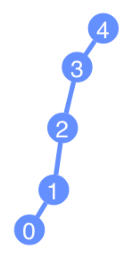

In [1]:
from qiskit.visualization import plot_gate_map
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler.coupling import CouplingMap

# Create a 5-qubit device with linear connectivity (0-1-2-3-4)
coupling_map = CouplingMap.from_line(5)
backend = GenericBackendV2(num_qubits=5, coupling_map=coupling_map, basis_gates=["cx", "u"])

# Visualize the device connectivity
plot_gate_map(backend)

## Compiling for Superconducting Devices

Let's start with a simple 5-qubit device with linear connectivity:

### Compile a 3-Qubit GHZ Circuit

Let's compile a simple 3-qubit GHZ state for this device:

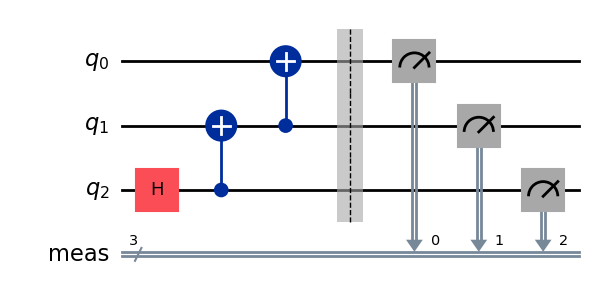

In [2]:
from mqt.qmap.plugins.qiskit.sc import compile
from mqt.bench import get_benchmark, BenchmarkLevel

# Load a 3-qubit GHZ circuit from MQT Bench
circ = get_benchmark(benchmark="ghz", level=BenchmarkLevel.ALG, circuit_size=3)
circ.draw(output="mpl")

In [3]:
# Compile the circuit to the device using MQT QMAP
circ_mapped, results = compile(circ, backend)

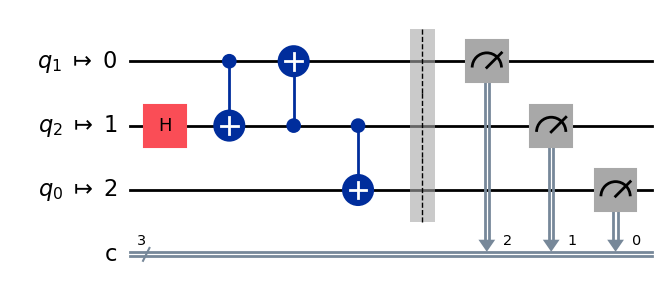

In [4]:
# Visualize the compiled circuit
circ_mapped.draw(output='mpl')

### Compile a 5-Qubit GHZ Circuit

Now let's try a circuit that uses all qubits on the device:

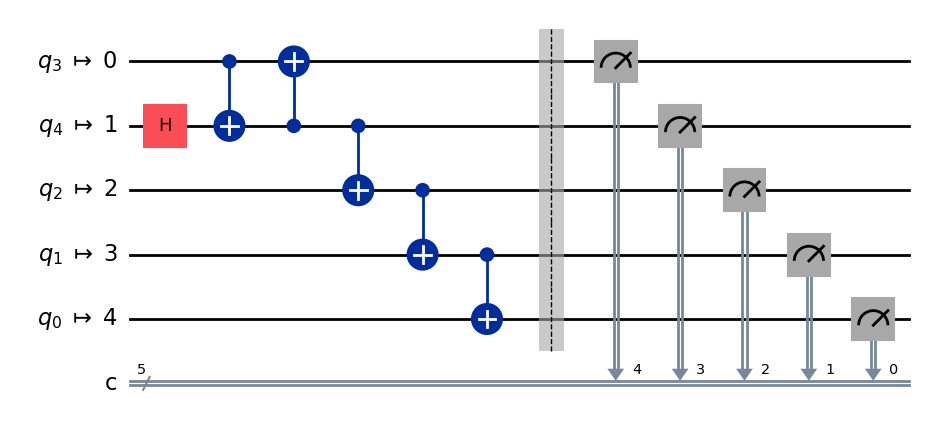

In [5]:
# Load and compile a 5-qubit GHZ circuit
circ = get_benchmark(benchmark="ghz", level=BenchmarkLevel.ALG, circuit_size=5)
circ_mapped, results = compile(circ, backend)
circ_mapped.draw(output='mpl')

### Compile a More Complex Circuit

Let's try Grover's algorithm, which requires more complex gate interactions:

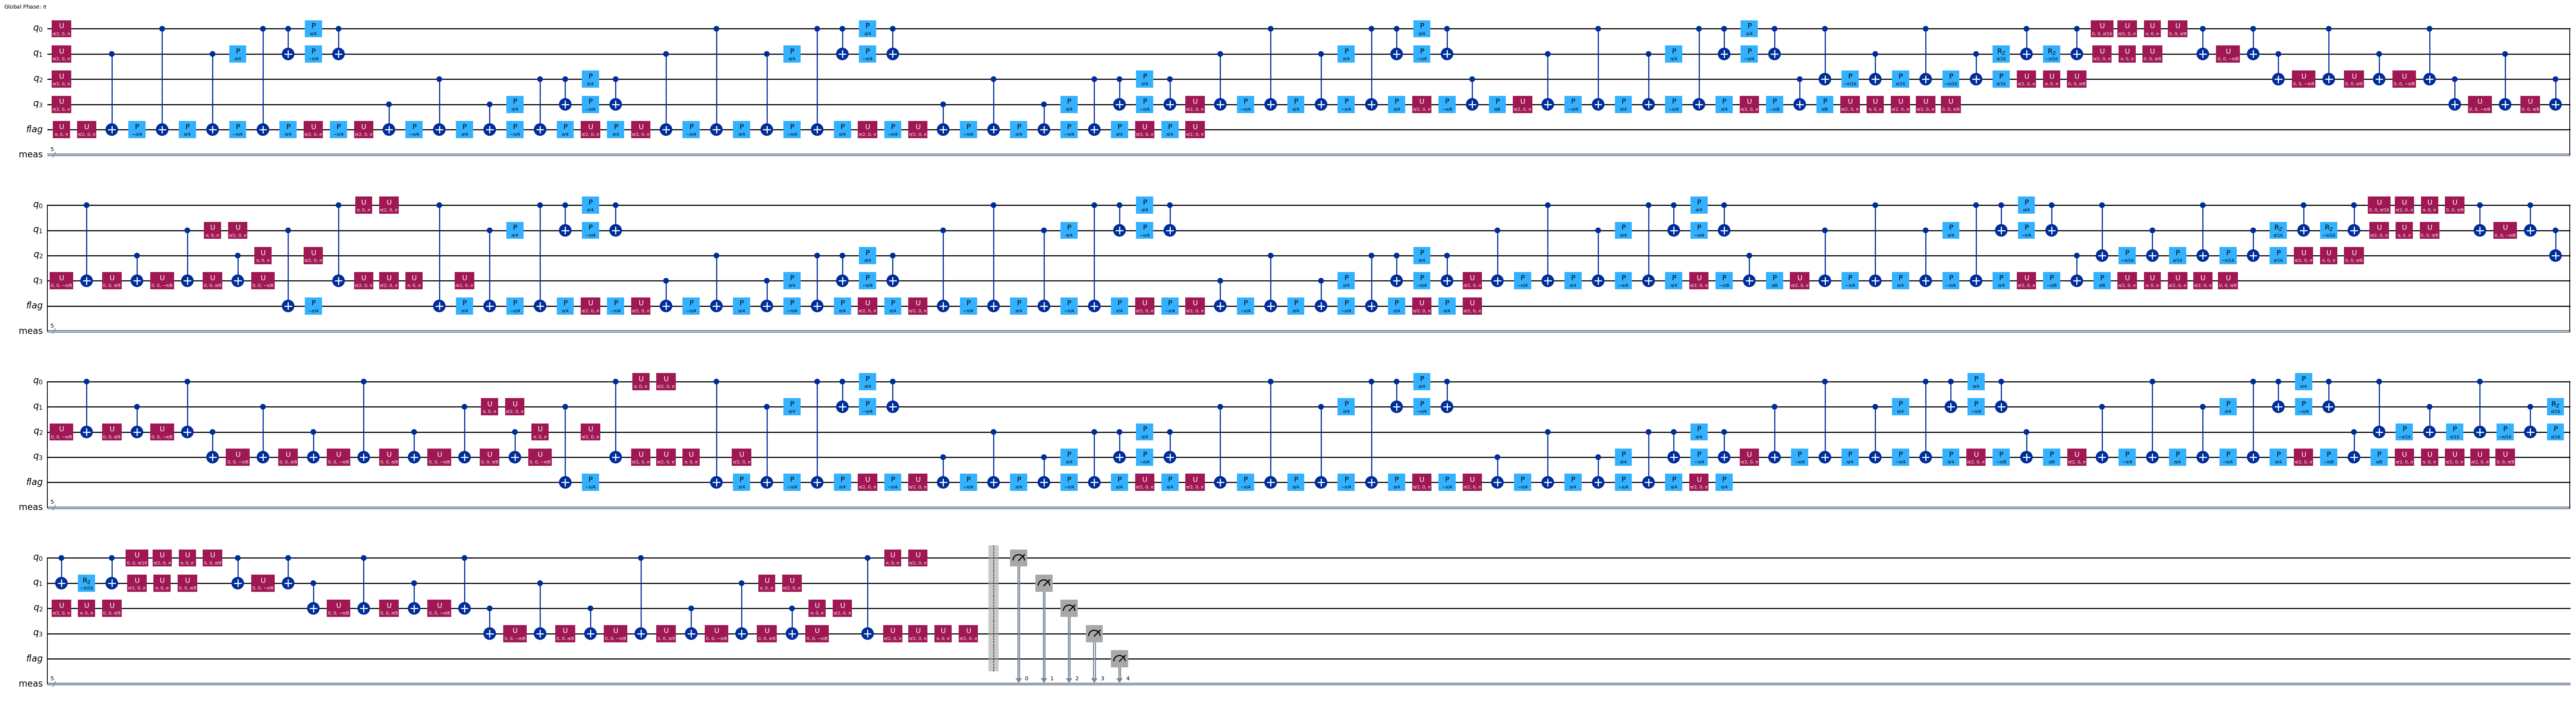

In [6]:
# Load a 5-qubit Grover circuit and decompose it
circ = get_benchmark(benchmark="grover", level=BenchmarkLevel.ALG, circuit_size=5).decompose(reps=3)
circ.draw(output="mpl", fold=100)

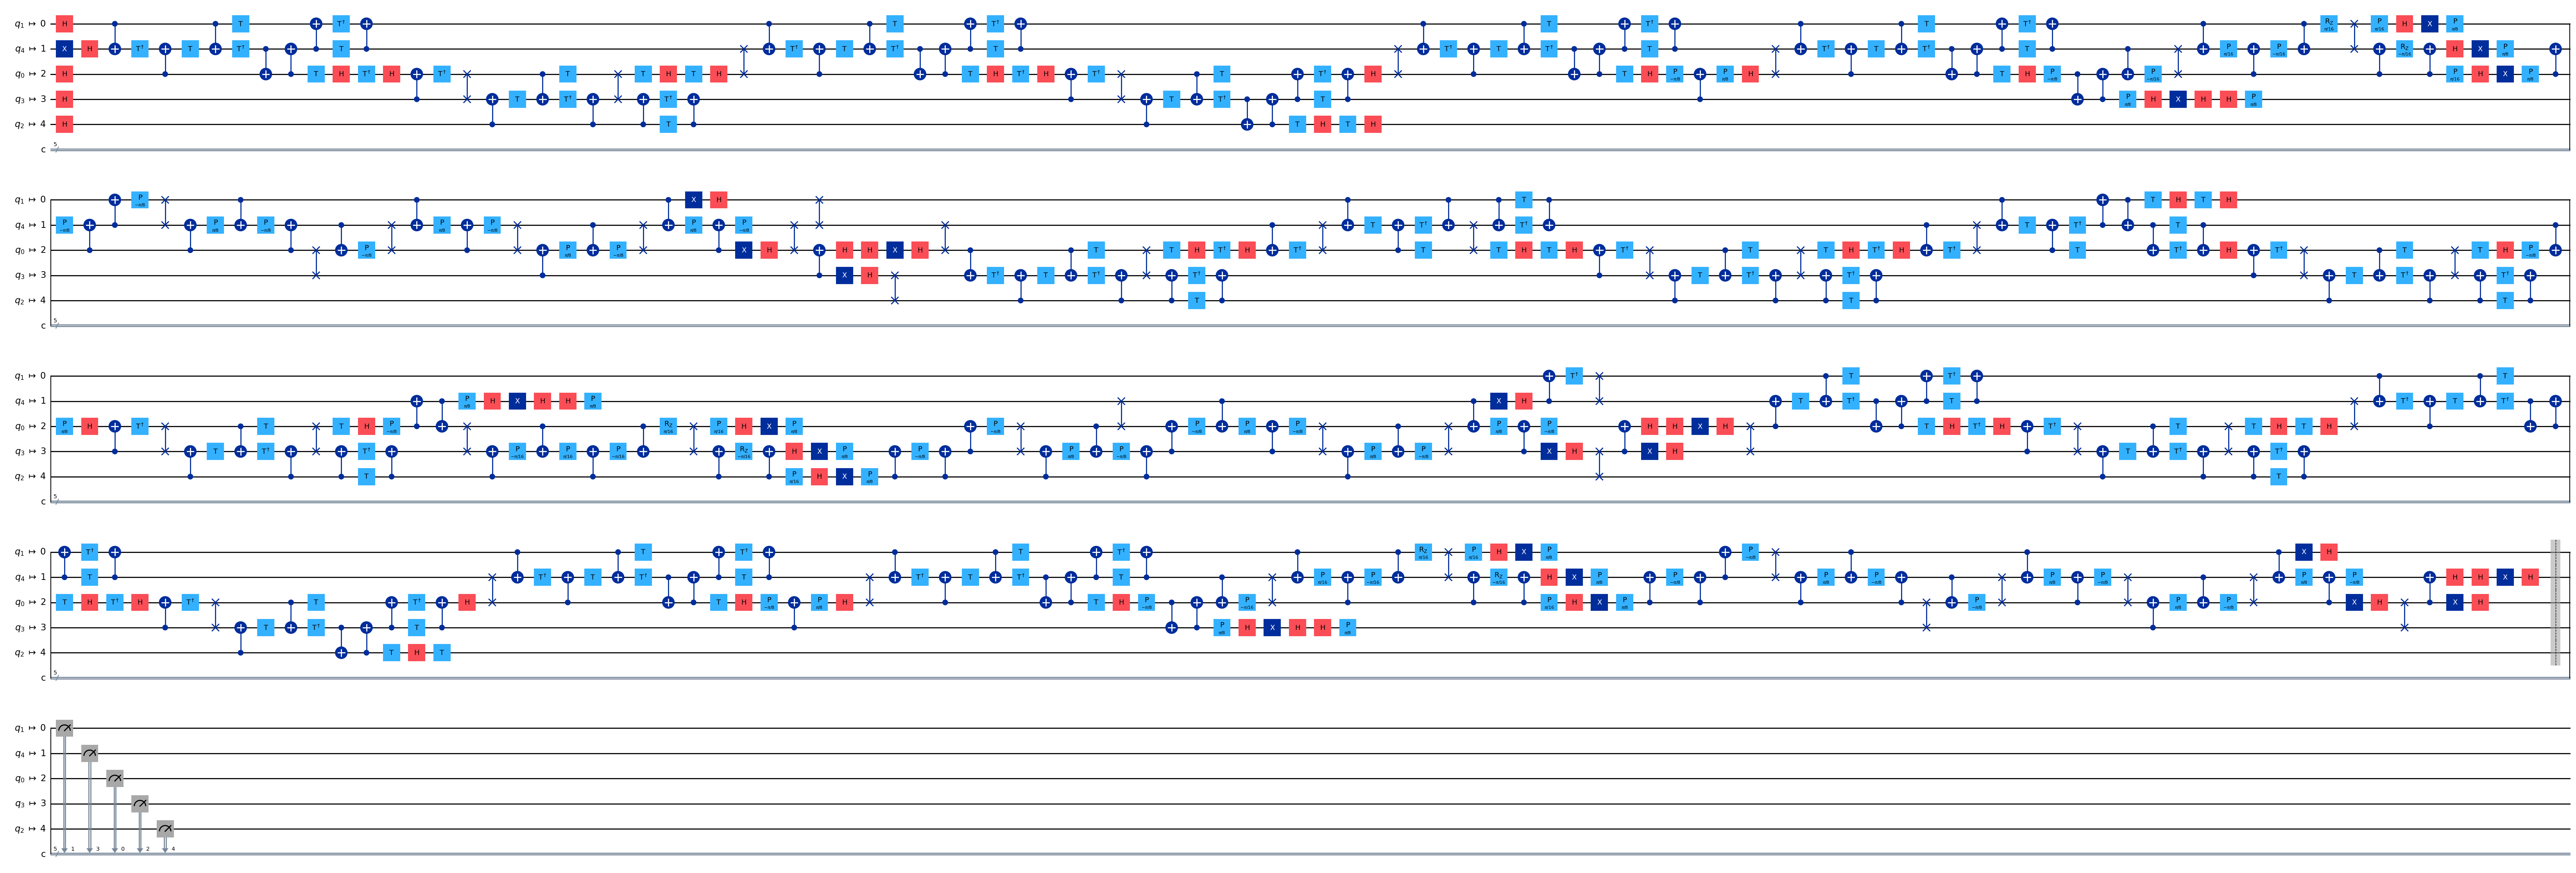

In [7]:
# Compile to the device
circ_mapped, results = compile(circ, backend)
circ_mapped.draw(output="mpl", fold=100)

In [8]:
# Count the gates in the compiled circuit
circ_mapped.count_ops()

OrderedDict([('cx', 188),
             ('t', 78),
             ('h', 76),
             ('p', 72),
             ('tdg', 60),
             ('swap', 50),
             ('x', 25),
             ('rz', 6),
             ('measure', 5),
             ('barrier', 1)])

### Comparison with Qiskit's Compiler

Let's compare MQT QMAP with Qiskit's built-in transpiler:

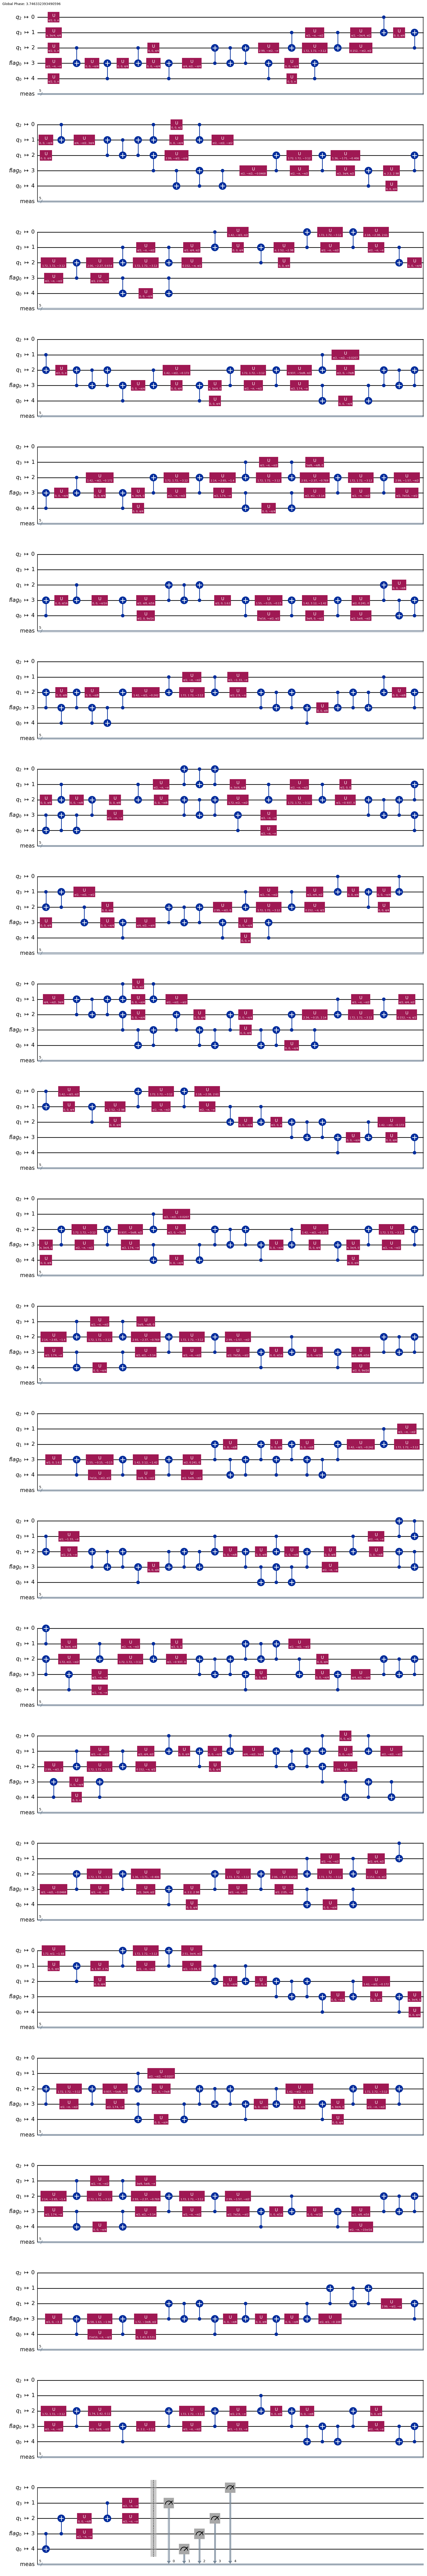

In [9]:
from qiskit import transpile

# Compile the same circuit using Qiskit's transpiler
circ_mapped_qiskit = transpile(circ, backend=backend)
circ_mapped_qiskit.draw(output='mpl')

In [10]:
# Compare gate counts
circ_mapped_qiskit.count_ops()

OrderedDict([('u', 330), ('cx', 321), ('measure', 5), ('barrier', 1)])

## Benchmarking on a Larger Device

Let's create a 9-qubit star-topology device and benchmark different compilation methods:

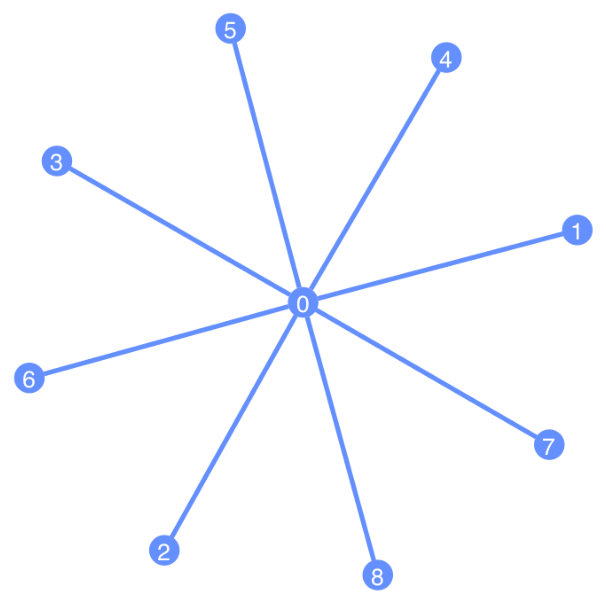

In [11]:
# Create a 9-qubit star-topology device (center qubit connects to all others)
coupling_map = [[0, 1], [1, 0], [0, 2], [2, 0], [0, 3], [3, 0], [0, 4], [4, 0], 
                [0, 5], [5, 0], [0, 6], [6, 0], [0, 7], [7, 0], [0, 8], [8, 0]]
backend = GenericBackendV2(num_qubits=9, coupling_map=coupling_map)
plot_gate_map(backend)

### Performance Comparison: QMAP vs Qiskit

Compare compilation quality (SWAP count) and speed for different methods:

In [12]:
import time
from mqt.qmap.sc import Method

# Initialize tracking lists
swaps_heuristic = []
swaps_exact = []
swaps_qiskit = []

times_heuristic = []
times_exact = []
times_qiskit = []

# Test on circuits of increasing size
qubit_range = range(2, 9)
for i in qubit_range:
    print(f"Circuit size: {i}")
    circ = get_benchmark(benchmark="ae", level=BenchmarkLevel.ALG, circuit_size=i).decompose(reps=2)

    # MQT QMAP Heuristic method
    start_time = time.time()
    circ_mapped, results = compile(circ, backend, method=Method.heuristic)
    times_heuristic.append(time.time() - start_time)
    swaps_heuristic.append(circ_mapped.count_ops().get('swap', 0))
    print(f"  MQT QMAP Heuristic SWAPs: {swaps_heuristic[-1]}")

    # MQT QMAP Exact method
    start_time = time.time()
    circ_mapped, results = compile(circ, backend, method=Method.exact)
    times_exact.append(time.time() - start_time)
    swaps_exact.append(circ_mapped.count_ops().get('swap', 0))
    print(f"  MQT QMAP Exact SWAPs: {swaps_exact[-1]}")

    # Qiskit transpiler
    start_time = time.time()
    circ_mapped = transpile(circ, coupling_map=coupling_map, optimization_level=3)
    times_qiskit.append(time.time() - start_time)
    swaps_qiskit.append(circ_mapped.count_ops().get('swap', 0))
    print(f"  Qiskit SWAPs: {swaps_qiskit[-1]}")
    
    print("----")

Circuit size: 2
  MQT QMAP Heuristic SWAPs: 0
  MQT QMAP Exact SWAPs: 0
  Qiskit SWAPs: 0
----
Circuit size: 3
  MQT QMAP Heuristic SWAPs: 3
  MQT QMAP Exact SWAPs: 3
  Qiskit SWAPs: 1
----
Circuit size: 4
  MQT QMAP Heuristic SWAPs: 5
  MQT QMAP Exact SWAPs: 3
  Qiskit SWAPs: 2
----
Circuit size: 5
  MQT QMAP Heuristic SWAPs: 11
  MQT QMAP Exact SWAPs: 10
  Qiskit SWAPs: 5
----
Circuit size: 6
  MQT QMAP Heuristic SWAPs: 12
  MQT QMAP Exact SWAPs: 3
  Qiskit SWAPs: 1
----
Circuit size: 4
  MQT QMAP Heuristic SWAPs: 5
  MQT QMAP Exact SWAPs: 3
  Qiskit SWAPs: 2
----
Circuit size: 5
  MQT QMAP Heuristic SWAPs: 11
  MQT QMAP Exact SWAPs: 10
  Qiskit SWAPs: 5
----
Circuit size: 6
  MQT QMAP Heuristic SWAPs: 12
  MQT QMAP Exact SWAPs: 8
  Qiskit SWAPs: 6
----
Circuit size: 7
  MQT QMAP Heuristic SWAPs: 17
  MQT QMAP Exact SWAPs: 14
  Qiskit SWAPs: 8
----
Circuit size: 8
  MQT QMAP Heuristic SWAPs: 18
  MQT QMAP Exact SWAPs: 17
  Qiskit SWAPs: 9
----
  MQT QMAP Exact SWAPs: 8
  Qiskit SWAPs

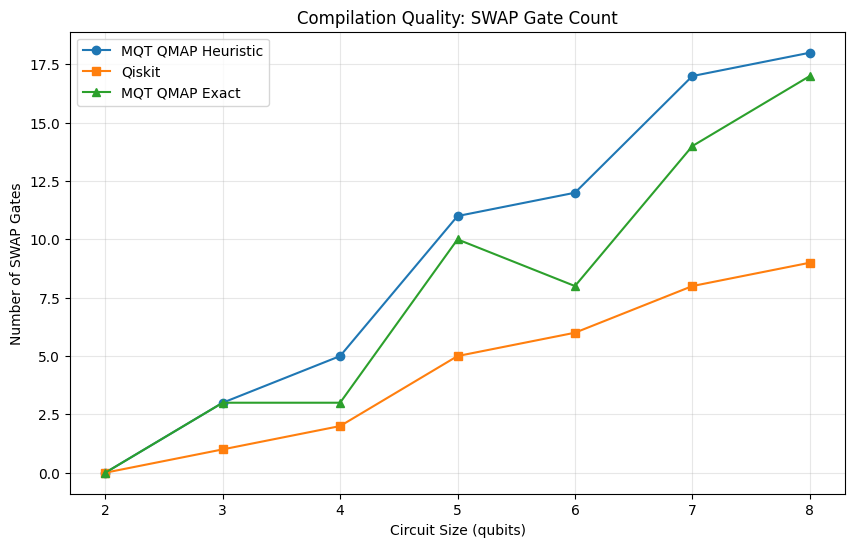

In [13]:
from matplotlib import pyplot as plt

# Plot SWAP gate comparison
plt.figure(figsize=(10, 6))
plt.xlabel("Circuit Size (qubits)")
plt.ylabel("Number of SWAP Gates")
plt.title("Compilation Quality: SWAP Gate Count")
plt.plot(qubit_range, swaps_heuristic, marker='o', label="MQT QMAP Heuristic")
plt.plot(qubit_range, swaps_qiskit, marker='s', label="Qiskit")
plt.plot(qubit_range, swaps_exact, marker='^', label="MQT QMAP Exact")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Compilation Time Comparison

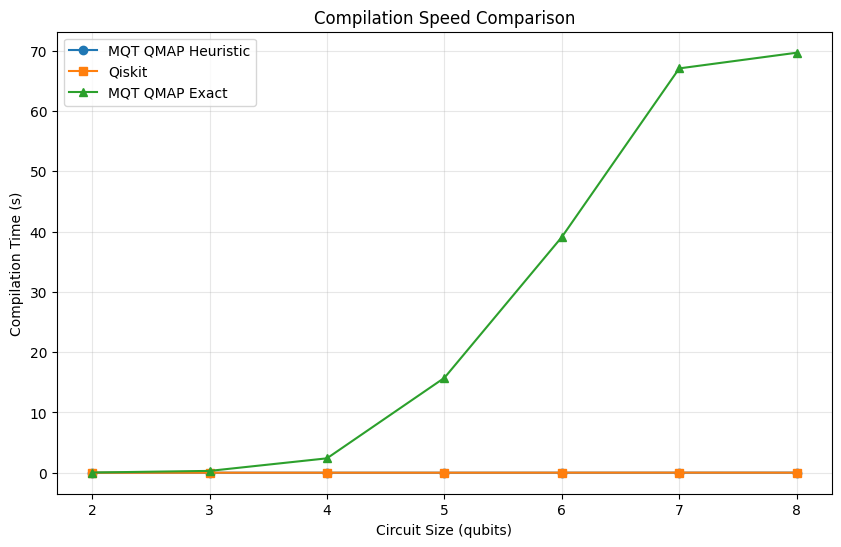

In [14]:
# Plot compilation time comparison
plt.figure(figsize=(10, 6))
plt.xlabel("Circuit Size (qubits)")
plt.ylabel("Compilation Time (s)")
plt.title("Compilation Speed Comparison")
plt.plot(qubit_range, times_heuristic, marker='o', label="MQT QMAP Heuristic")
plt.plot(qubit_range, times_qiskit, marker='s', label="Qiskit")
plt.plot(qubit_range, times_exact, marker='^', label="MQT QMAP Exact")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Neutral atom compilation

Neutral-atom platforms offer flexible qubit layouts by dynamically rearranging atoms with optical tweezers. This enables effective all-to-all connectivity, reducing the need for swap-heavy routing strategies.  

Specialized entanglement zones permit multi-qubit interactions. A compiler must therefore determine when and how to transport atoms efficiently between interaction and storage regions.

In [15]:
from mqt.qmap.na.zoned import ZonedNeutralAtomArchitecture

arch = ZonedNeutralAtomArchitecture.from_json_string("""{
  "name": "Architecture with one entanglement and one storage zone",
  "operation_duration": {"rydberg_gate": 0.36, "single_qubit_gate": 52, "atom_transfer": 15},
  "operation_fidelity": {"rydberg_gate": 0.995, "single_qubit_gate": 0.9997, "atom_transfer": 0.999},
  "qubit_spec": {"T": 1.5e6},
  "storage_zones": [{
    "zone_id": 0,
    "slms": [{"id": 0, "site_separation": [3, 3], "r": 20, "c": 100, "location": [0, 0]}],
    "offset": [0, 0],
    "dimension": [297, 57]
  }],
  "entanglement_zones": [{
    "zone_id": 0,
    "slms": [
      {"id": 1, "site_separation": [12, 10], "r": 7, "c": 20, "location": [35, 67]},
      {"id": 2, "site_separation": [12, 10], "r": 7, "c": 20, "location": [37, 67]}
    ],
    "offset": [35, 67],
    "dimension": [230, 60]
  }],
  "aods": [{"id": 0, "site_separation": 2, "r": 100, "c": 100}],
  "rydberg_range": [[[30, 62], [270, 132]]]
}""")

### Create an 8-Qubit GHZ Circuit

Define a circuit using global rotations and CZ gates (native to neutral atoms):

### Define a Neutral Atom Architecture

Create an architecture with one storage zone and one entanglement zone:

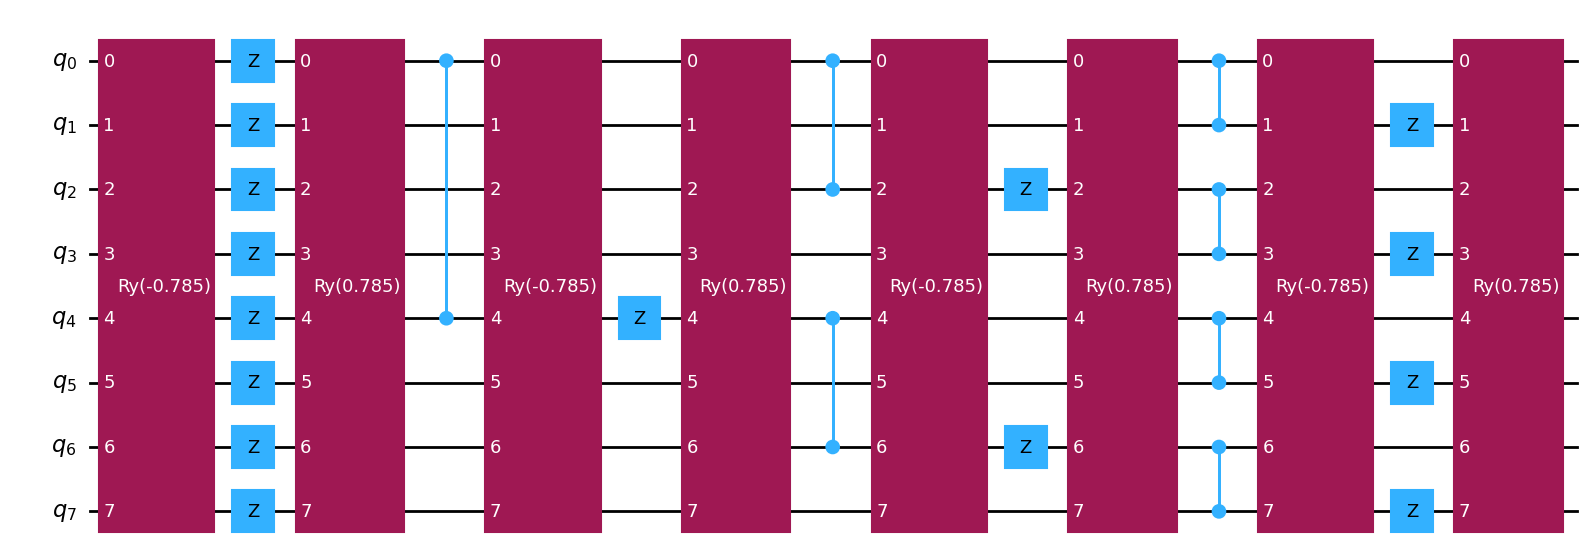

In [16]:
from qiskit import QuantumCircuit
from numpy import pi

def global_ry(theta, num_qubits):
    """:returns: a global ry gate"""
    qc = QuantumCircuit(num_qubits)
    qc.ry(theta, range(num_qubits))
    return qc.to_gate(label = f"Ry({theta:.3f})")


qc = QuantumCircuit(8)
qc.append(global_ry(-pi/4, 8), range(8))
qc.z(range(8))
qc.append(global_ry(pi/4, 8), range(8))
qc.cz(0, 4)
qc.append(global_ry(-pi/4, 8), range(8))
qc.z(4)
qc.append(global_ry(pi/4, 8), range(8))
qc.cz(0, 2)
qc.cz(4, 6)
qc.append(global_ry(-pi/4, 8), range(8))
qc.z([2, 6])
qc.append(global_ry(pi/4, 8), range(8))
qc.cz(0, 1)
qc.cz(2, 3)
qc.cz(4, 5)
qc.cz(6, 7)
qc.append(global_ry(-pi/4, 8), range(8))
qc.z([1,3,5,7])
qc.append(global_ry(pi/4, 8), range(8))

qc.draw(output="mpl")

In [17]:
from mqt.qmap.na.zoned import RoutingAgnosticCompiler, RoutingAwareCompiler

compiler = RoutingAwareCompiler(arch)
# or if you want to use the routing-agnostic compiler:
# compiler = RoutingAgnosticCompiler(arch)

### Compile with Routing-Aware Compiler

The routing-aware compiler optimizes atom movements based on the circuit structure:

In [18]:
from mqt.core import load

circ = load(qc)
code = compiler.compile(circ)
print(code)

atom (0.000, 57.000) atom0
atom (3.000, 57.000) atom1
atom (6.000, 57.000) atom2
atom (9.000, 57.000) atom3
atom (12.000, 57.000) atom4
atom (15.000, 57.000) atom5
atom (18.000, 57.000) atom6
atom (21.000, 57.000) atom7
@+ ry -0.78540 global
@+ rz 3.14159 atom0
@+ rz 3.14159 atom1
@+ rz 3.14159 atom2
@+ rz 3.14159 atom3
@+ rz 3.14159 atom4
@+ rz 3.14159 atom5
@+ rz 3.14159 atom6
@+ rz 3.14159 atom7
@+ ry 0.78540 global
@+ load [
    atom0
    atom4
]
@+ move [
    (35.000, 67.000) atom0
    (37.000, 67.000) atom4
]
@+ store [
    atom0
    atom4
]
@+ cz zone_cz0
@+ load atom4
@+ move (36.000, 57.000) atom4
@+ store atom4
@+ ry -0.78540 global
@+ rz 3.14159 atom4
@+ ry 0.78540 global
@+ load atom2
@+ move (37.000, 67.000) atom2
@+ store atom2
@+ load [
    atom6
    atom4
]
@+ move [
    (35.000, 77.000) atom6
    (37.000, 77.000) atom4
]
@+ store [
    atom6
    atom4
]
@+ cz zone_cz0
@+ load atom2
@+ move (38.000, 68.000) atom2
@+ load atom6
@+ move [
    (24.000, 57.000) atom6
    (2

The compiler can be configured with different parameters, e.g., the deepening factor of the A*-placer:

In [19]:
compiler = RoutingAwareCompiler(arch, deepening_factor = 0.6)

circ = load(qc)
code = compiler.compile(circ)
print(code)

# save to .naviz file
with open("compiled_circuit.naviz", "w") as f:
    f.write(code)

atom (0.000, 57.000) atom0
atom (3.000, 57.000) atom1
atom (6.000, 57.000) atom2
atom (9.000, 57.000) atom3
atom (12.000, 57.000) atom4
atom (15.000, 57.000) atom5
atom (18.000, 57.000) atom6
atom (21.000, 57.000) atom7
@+ ry -0.78540 global
@+ rz 3.14159 atom0
@+ rz 3.14159 atom1
@+ rz 3.14159 atom2
@+ rz 3.14159 atom3
@+ rz 3.14159 atom4
@+ rz 3.14159 atom5
@+ rz 3.14159 atom6
@+ rz 3.14159 atom7
@+ ry 0.78540 global
@+ load [
    atom0
    atom4
]
@+ move [
    (35.000, 67.000) atom0
    (37.000, 67.000) atom4
]
@+ store [
    atom0
    atom4
]
@+ cz zone_cz0
@+ load atom4
@+ move (36.000, 57.000) atom4
@+ store atom4
@+ ry -0.78540 global
@+ rz 3.14159 atom4
@+ ry 0.78540 global
@+ load atom2
@+ move (37.000, 67.000) atom2
@+ store atom2
@+ load [
    atom6
    atom4
]
@+ move [
    (35.000, 77.000) atom6
    (37.000, 77.000) atom4
]
@+ store [
    atom6
    atom4
]
@+ cz zone_cz0
@+ load atom2
@+ move (38.000, 68.000) atom2
@+ load atom6
@+ move [
    (24.000, 57.000) atom6
    (2

## Visualizing with NAViz

The compilation output is in a `.naviz` string, that can be opened with NAViz.
Simply copy past the output sting into a browser window or import the saved `.naviz` file there:

https://munich-quantum-toolkit.github.io/naviz/

## Compilation for Neutral Atom Quantum Computers

Neutral atom platforms offer unique advantages through dynamic atom rearrangement:tasks:

- Choose different algorithms from MQT Bench (see https://mqt.readthedocs.io/projects/bench/en/latest/Benchmark_selection.html)
- Adjust size and connectivity of considered backend (see https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.CouplingMap -> e.g., from_line, from_ring, from_full)